# Computing Timelags: Bundle Model

Compute the timelags for our bundle model.

In [18]:
import os
import sys

import numpy as np
from scipy.interpolate import splprep,splev
import distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils.console import ProgressBar

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append('../../scripts/')
from timelags import AIATimeLags
from idl_colormaps import bgry_004_idl_cmap

%matplotlib inline

Spin up a Dask distributed cluster.

In [2]:
cluster = distributed.LocalCluster(threads_per_worker=1,)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33310 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Load the data and write it to a single HDF5 file. This makes data access later on much easier.

In [3]:
FREQUENCY = 'bundle'

In [4]:
aia = InstrumentSDOAIA([5000,25000]*u.s, None)
aia.counts_file = f'/storage-home/w/wtb2/data/timelag_synthesis_v2/{FREQUENCY}/SDO_AIA_counts.h5'

In [5]:
tl = AIATimeLags(
    aia,
    f'/storage-home/w/wtb2/data/timelag_synthesis_v2/{FREQUENCY}/timelags/mapcube.h5',
    fits_root_path=f'/storage-home/w/wtb2/data/timelag_synthesis_v2/{FREQUENCY}'
)

FloatProgress(value=0.0)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


Plot a pixel-averaged light curve from the data we loaded.

In [6]:
xc,yc = -325*u.arcsec, -200*u.arcsec
dx,dy = 1*u.arcsec, 1*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)
coords  = (lower_left_corner,upper_right_corner)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


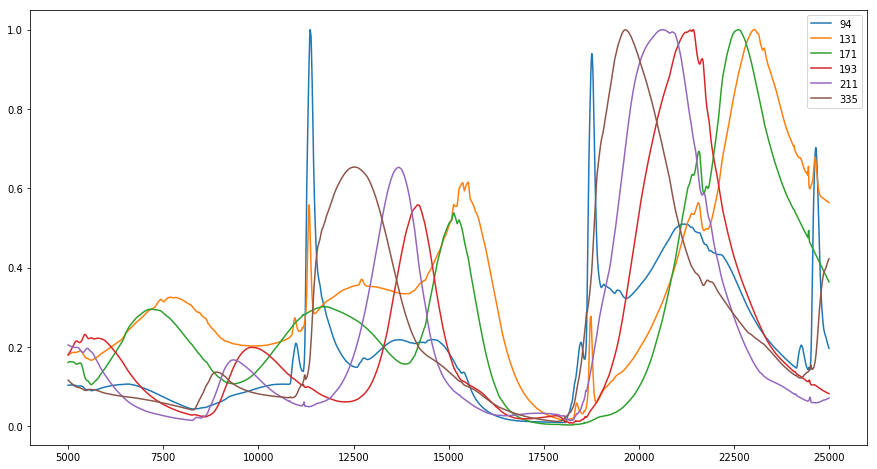

In [7]:
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
for i,channel in enumerate(aia.channels,):
    ts = tl.make_timeseries(channel['name'],lower_left_corner,upper_right_corner)
    ax.plot(aia.observing_time,ts/ts.max(),color=f'C{i}',label=channel['name'])
ax.legend()

And then plot the timelags for this same group of averaged pixels for a selected number of channel pairs.

In [8]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


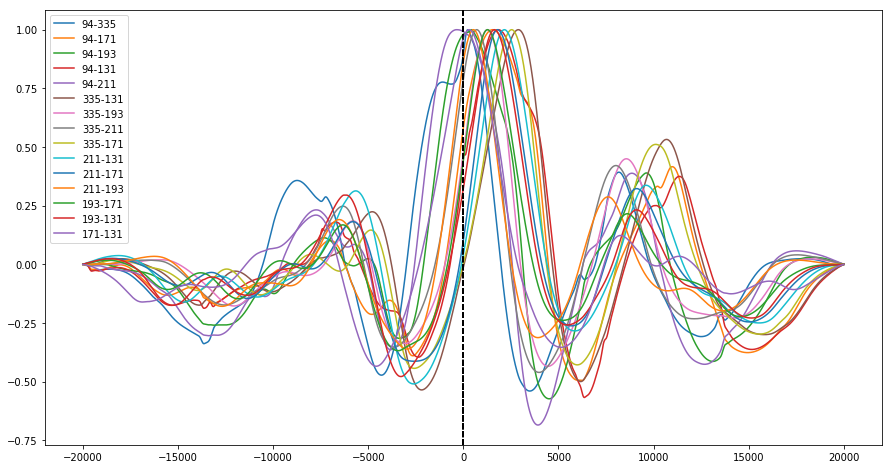

In [9]:
fig = plt.figure(figsize=(15,8),)
ax = fig.gca()
for i,p in enumerate(channel_pairs,):
    # cooling
    cc = tl.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl.timelags,cc/cc.max(), color=f'C{i%10}', ls='-', label='{}-{}'.format(*p))
    ax.axvline(x=0,ls='--',color='k')
#axes[0,0].set_xlim([-5e3,5e3])
ax.legend(loc=2)

Now, compute the timelag and correlation maps for all of the channel pairs.

In [10]:
timelag_bounds = (-6*u.hour,6*u.hour)

In [11]:
timelag_maps = {}
correlation_maps = {}
with ProgressBar(len(channel_pairs),ipython_widget=True) as prog:
    for p in channel_pairs:
        tl_map, cor_map = tl.make_timelag_map(f'{p[0]}',f'{p[1]}',
                                              timelag_bounds=timelag_bounds,
                                              return_correlation_map=True)
        timelag_maps['{}-{}'.format(*p)] = tl_map
        correlation_maps['{}-{}'.format(*p)] = cor_map
        prog.update()

FloatProgress(value=0.0)

And plot the maps.

In [12]:
correlation_cutoff = 500.0

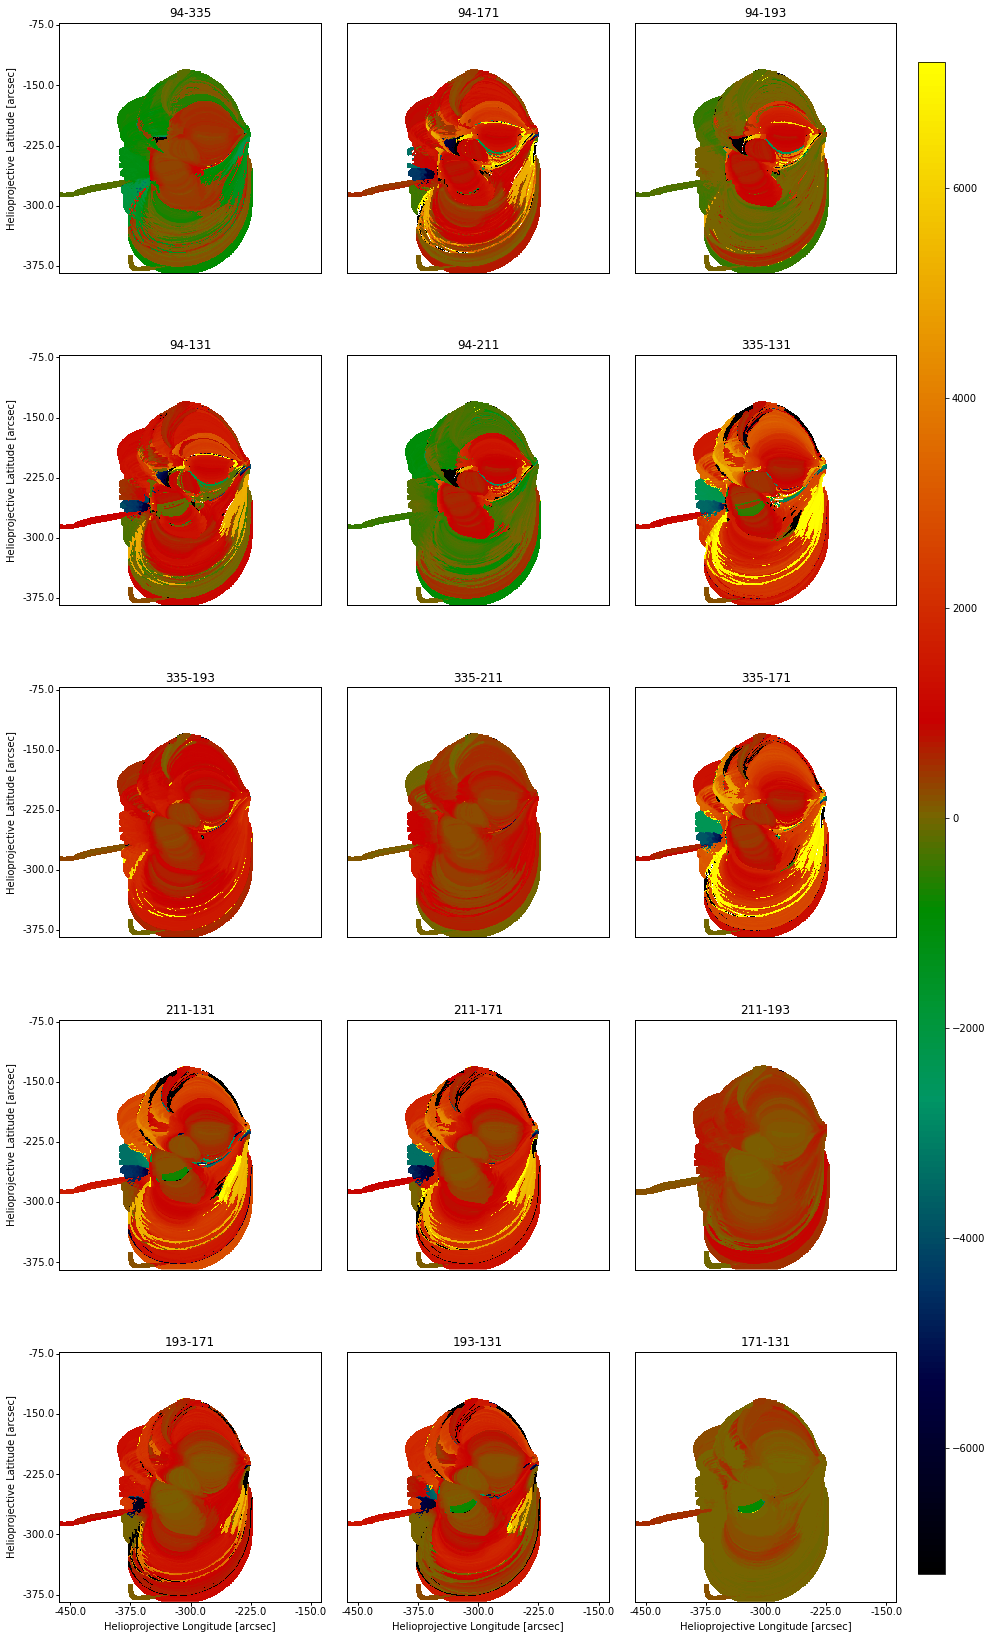

In [32]:
fig = plt.figure(figsize=(15,30))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = Map(timelag_maps['{}-{}'.format(*cp)])
    m_cor = Map(correlation_maps['{}-{}'.format(*cp)])
    data = np.where((m_cor.data) < correlation_cutoff, np.nan, m.data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(5, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=-(2*u.hour).to(u.s).value,
                vmax=(2*u.hour).to(u.s).value,
                cmap=bgry_004_idl_cmap)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 11:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

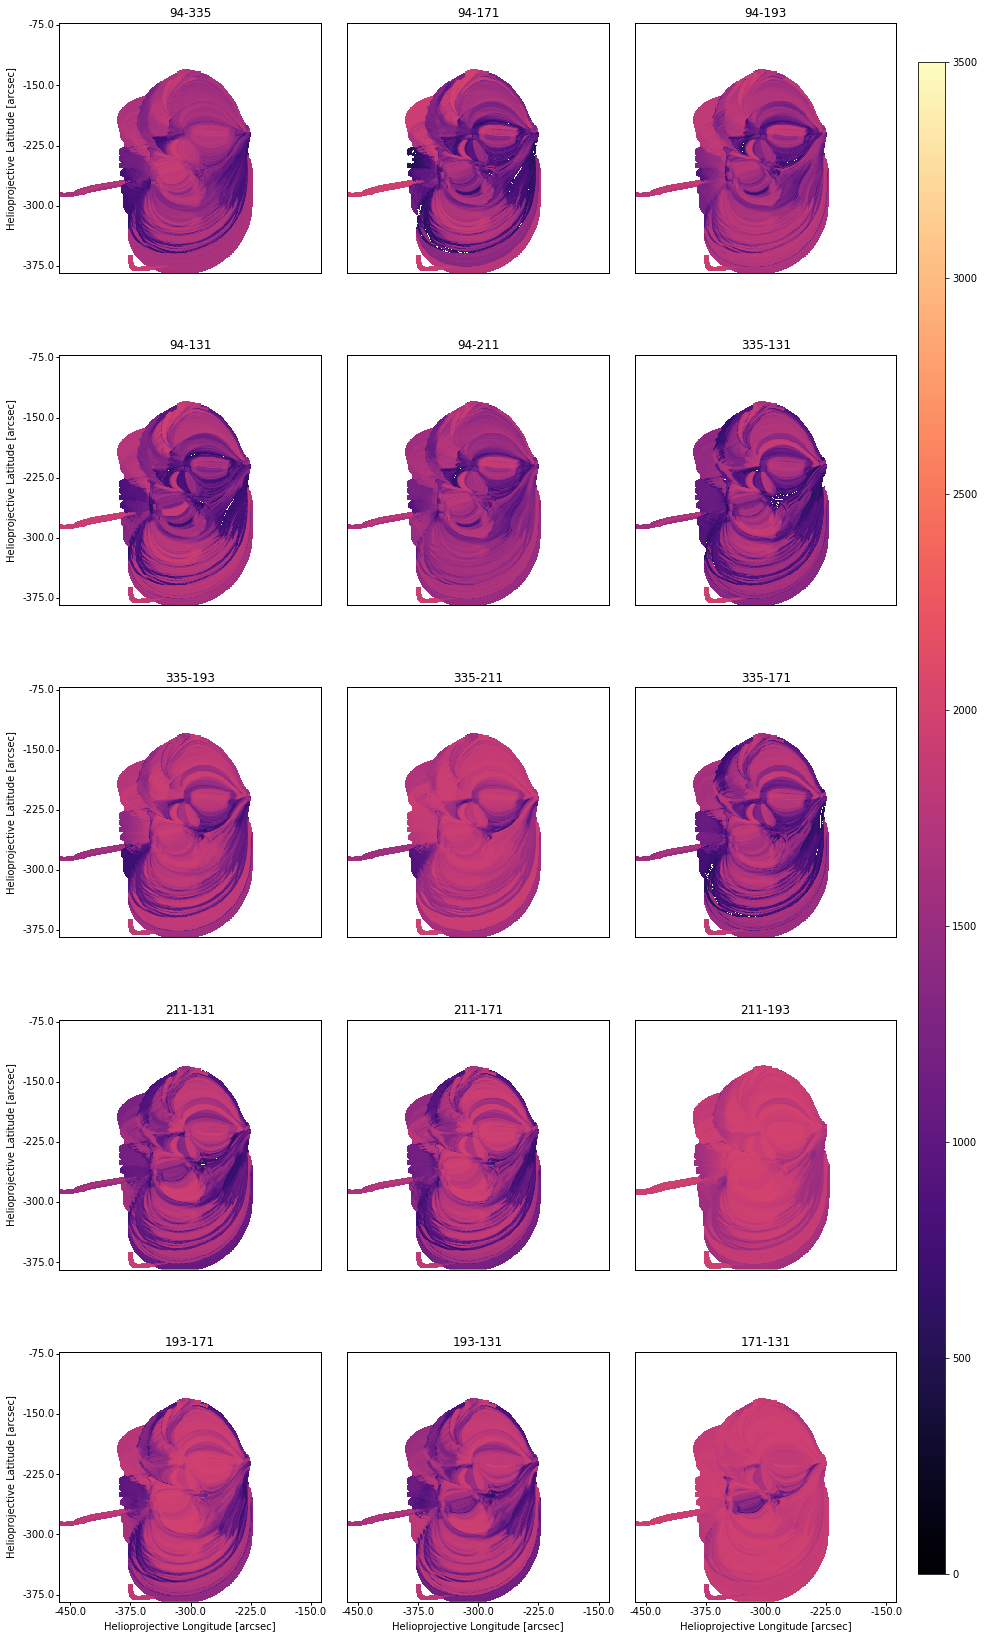

In [15]:
fig = plt.figure(figsize=(15,30))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = correlation_maps['{}-{}'.format(*cp)]
    data = np.where(m.data < correlation_cutoff, np.nan, m.data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(5, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=0, vmax=3.5e3, cmap='magma')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 11:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

Make a comparison between the observed and bundle distributions.

In [16]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [19]:
ds = 0.5*u.Mm
stacked_coords = None
for loop in field.loops:
    knots, _ = splprep(loop.coordinates.cartesian.xyz.value)
    n_interp = int(np.ceil((loop.full_length/ds).decompose()))
    tmp = np.array(splev(np.linspace(0, 1, n_interp), knots))
    if stacked_coords is None:
        stacked_coords = tmp
    else:
        stacked_coords = np.hstack([stacked_coords, tmp])
stacked_coords = u.Quantity(stacked_coords, loop.coordinates.cartesian.xyz.unit)
stacked_coords = SkyCoord(x=stacked_coords[0,:],y=stacked_coords[1,:],z=stacked_coords[2,:],
                          frame='heliographic_stonyhurst',representation='cartesian')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [20]:
sample_obs_map = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/timelag_171_131.fits')

In [21]:
core_pixels = sample_obs_map.world_to_pixel(stacked_coords.transform_to('heliographic_stonyhurst').transform_to(sample_obs_map.coordinate_frame))

In [22]:
x_pixel_mask = core_pixels.x.value.round().astype(int)
y_pixel_mask = core_pixels.y.value.round().astype(int)
i_inbounds = np.where(np.logical_and(x_pixel_mask>=0, y_pixel_mask>=0))
x_pixel_mask = x_pixel_mask[i_inbounds]
y_pixel_mask = y_pixel_mask[i_inbounds]

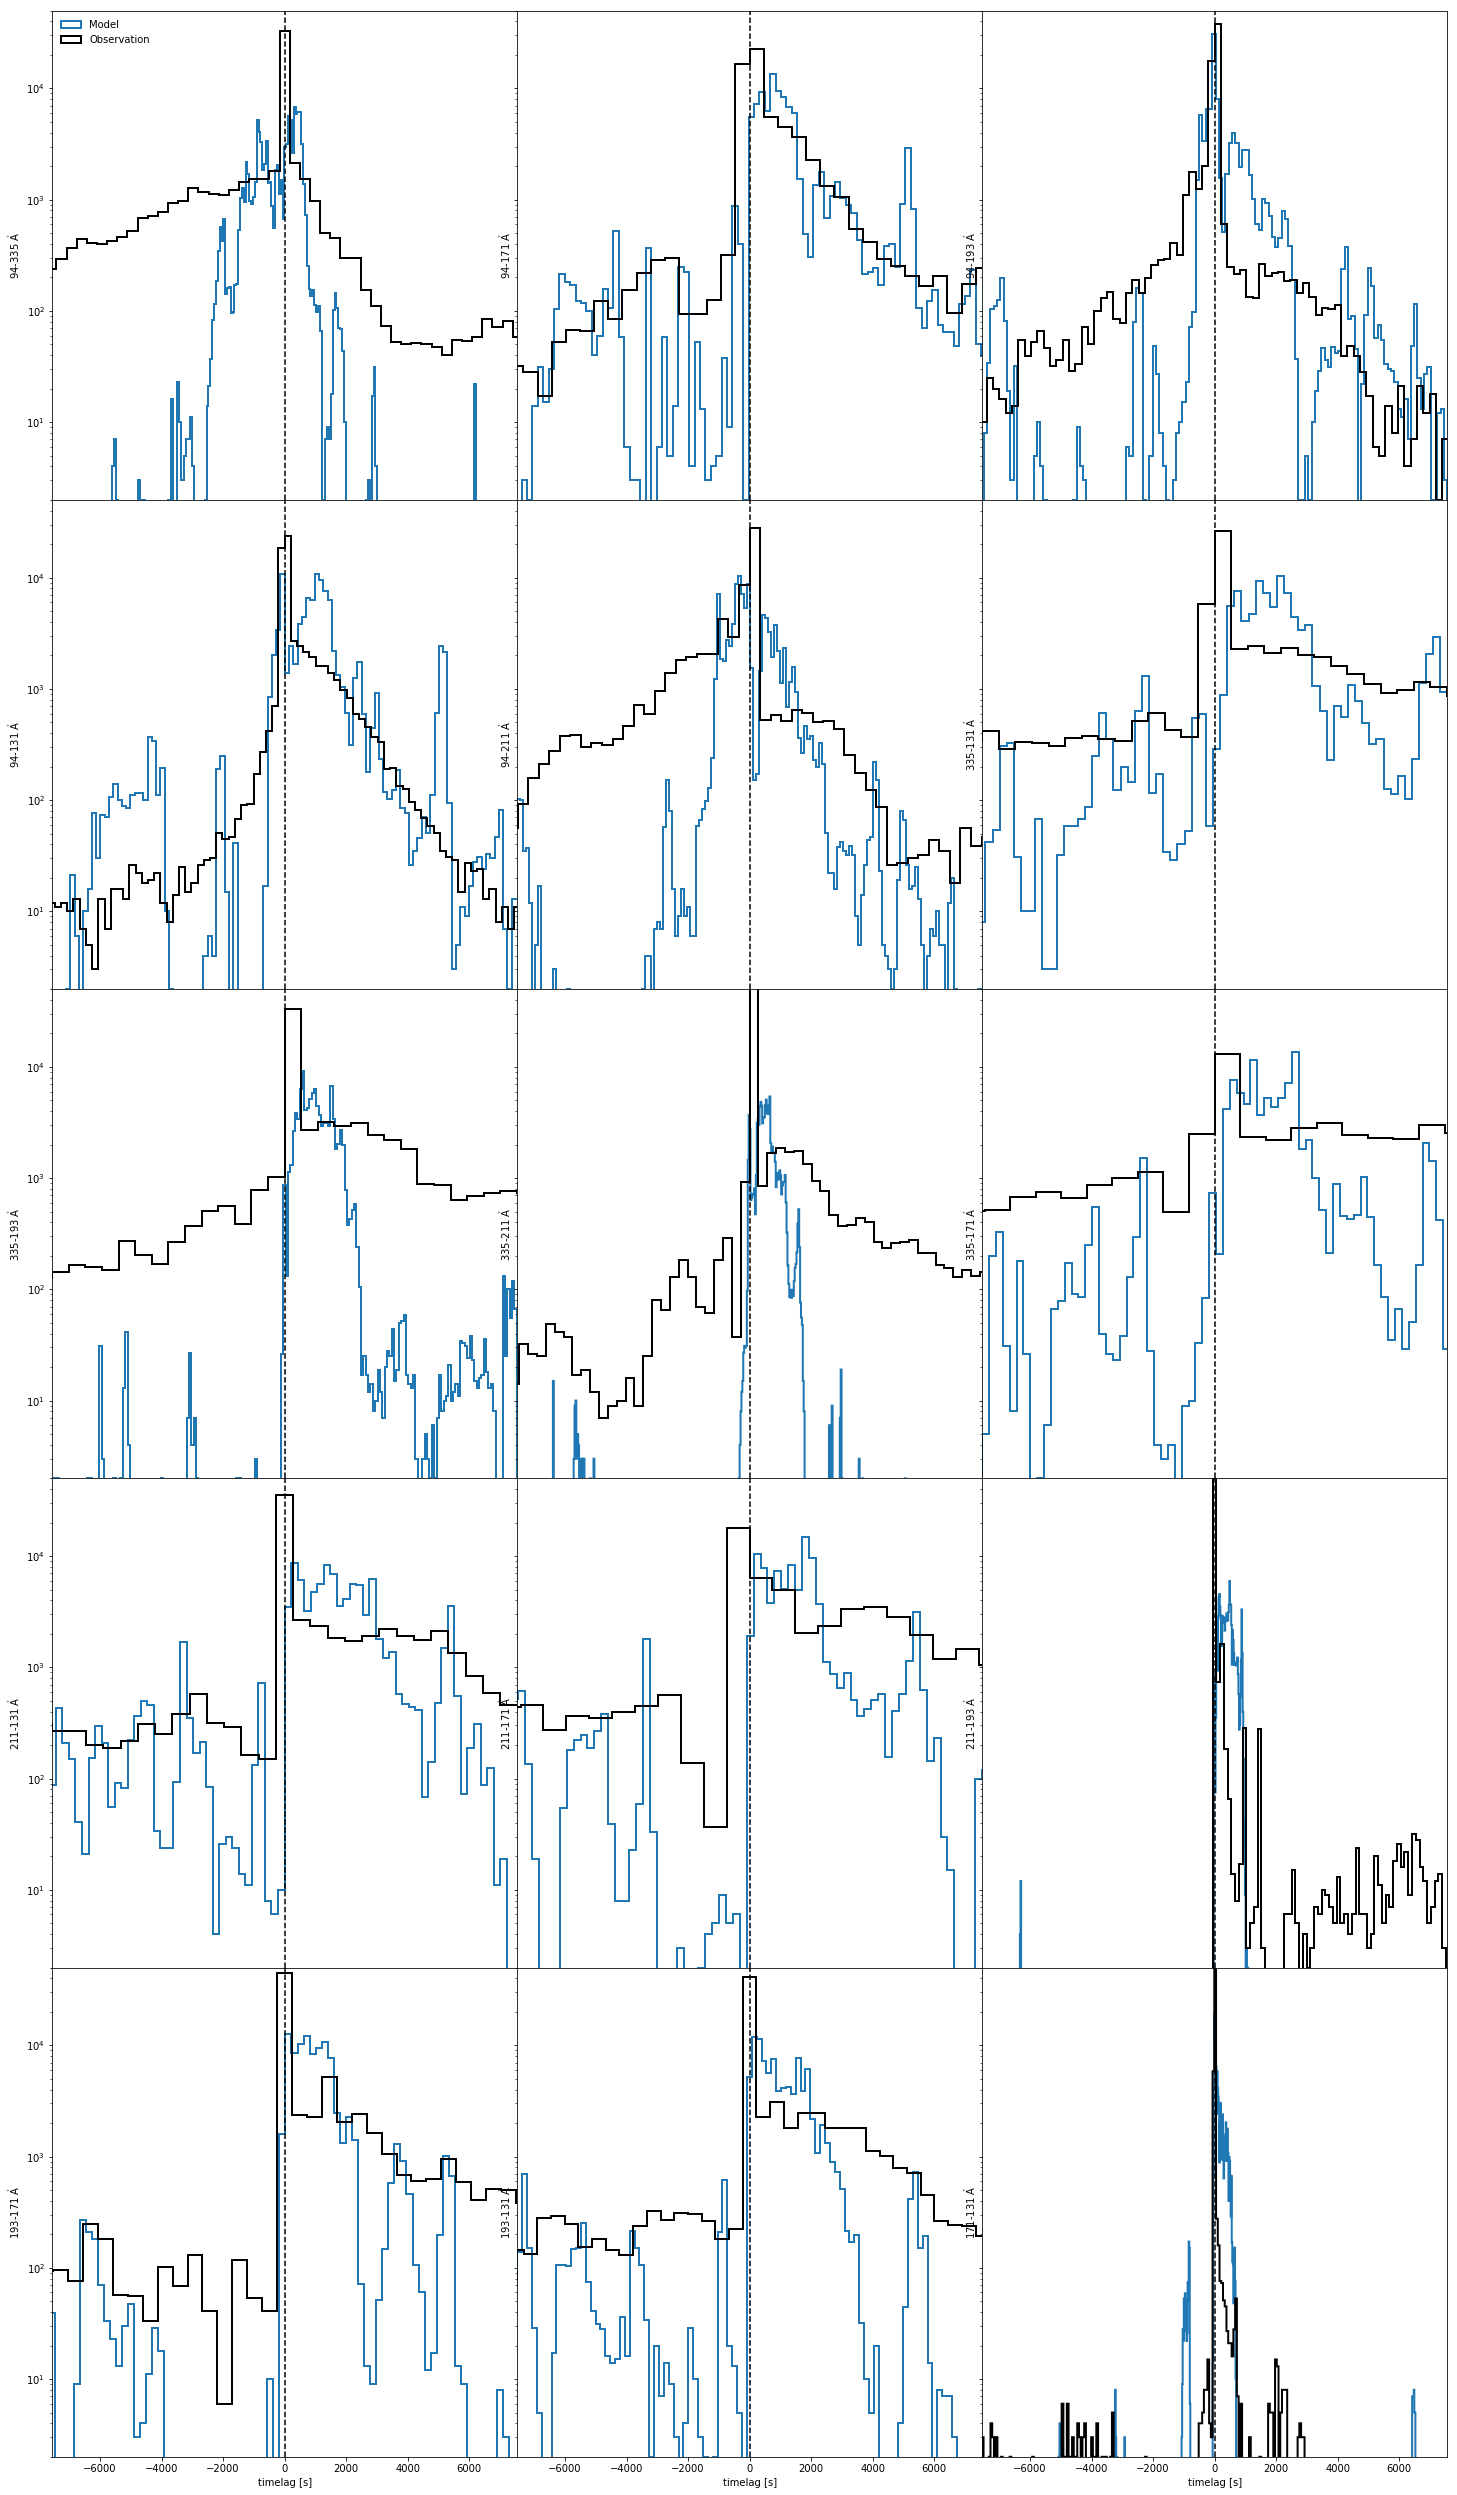

In [30]:
bins = np.linspace((-2*u.hour).to(u.s).value,(2*u.hour).to(u.s).value,50)
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'cumulative':False,'color':'C0','ls':'-','label': 'Model'}
params_obs = {**params.copy(), **{'label': 'Observation', 'color': 'k'}}
fig,axes = plt.subplots(5,3,figsize=(25,45),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for i,(c0,c1) in enumerate(channel_pairs):
    ax = axes.flatten()[i]
    # Get the observed data
    tmp = Map(f'/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/timelag_{c0}_{c1}.fits')
    mask = np.nan*np.ones(tmp.data.shape)
    mask[y_pixel_mask,x_pixel_mask] = tmp.data[y_pixel_mask,x_pixel_mask]
    tmp = Map(mask, tmp.meta)
    data = tmp.data.flatten()
    data = data[~np.isnan(data)]
    tmp = Map(f'/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/correlation_{c0}_{c1}.fits')
    mask = np.nan*np.ones(tmp.data.shape)
    mask[y_pixel_mask,x_pixel_mask] = tmp.data[y_pixel_mask,x_pixel_mask]
    tmp = Map(mask, tmp.meta)
    data_cor = tmp.data.flatten()
    data_cor = data_cor[~np.isnan(data_cor)]
    data_observed = data[np.where(data_cor >= correlation_cutoff)]
    # Get the model data
    tmp = timelag_maps[f'{c0}-{c1}']
    data = tmp.data.flatten()
    tmp = correlation_maps[f'{c0}-{c1}']
    data_cor = tmp.data.flatten()
    data_model = data[np.where(data_cor >= correlation_cutoff)]
    # Plot the distributions
    ax.hist(data_model, **params,)
    ax.axvline(x=0,ls='--',color='k')
    ax.hist(data_observed,**params_obs,)
    ax.set_ylabel(f'{c0}-{c1} $\mathrm{{\mathring{{A}}}}$')
    if i > 11:
        ax.set_xlabel(r'timelag [s]')
    if i == 0:
        ax.legend(loc=2,frameon=False)
axes[0,0].set_xlim(-(2.1*u.hour).to(u.s).value, (2.1*u.hour).to(u.s).value);
axes[0,0].set_ylim(2,5e4);

Finally, we want to save the maps for all of the channel pairs so that we can analyze them later.

In [34]:
# save maps here
fitsfile = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{frequency}/timelags/{type}_{c0}_{c1}.fits'
for p in channel_pairs:
    timelag_maps['{}-{}'.format(*p)].save(fitsfile.format(frequency=FREQUENCY, type='timelag', c0=p[0], c1=p[1]))
    correlation_maps['{}-{}'.format(*p)].save(fitsfile.format(frequency=FREQUENCY, type='correlation', c0=p[0], c1=p[1]))